# EY EXTRA SEATS conversion

In [ ]:
!pip install ipython-sql

In [19]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [20]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [4]:
query="""
SELECT * FROM ml_prep.gauthier_offer_load_dsb_ey_2019_2020_dataset ;
"""
raw_df = pd.read_sql_query(query, con)
raw_df.head(3)


event_time                          request_id  partner_id  \
0  2019-04-08T10:07:30Z  nFWn3WHBD9tryJlXSNLTVAhXzrOOcLKg5e          11   
1  2019-04-08T10:07:30Z  nFWn3WHBD9tryJlXSNLTVAhXzrOOcLKg5e          11   
2  2019-04-08T10:07:30Z  nFWn3WHBD9tryJlXSNLTVAhXzrOOcLKg5e          11   

  origin destination  flight_number departure_date departure_time from_cabin  \
0    AMD         AUH            289     2019-04-12          05:05    ECONOMY   
1    AUH         ORD            151     2019-04-12          10:50    ECONOMY   
2    AUH         AMD            288     2019-06-04          23:05    ECONOMY   

  upgrade_type  ... first_email_opened_time  last_email_opened_time  \
0   EXTRA_SEAT  ...     2019-04-08 10:04:20     2019-04-08 10:06:34   
1   EXTRA_SEAT  ...     2019-04-08 10:04:20     2019-04-08 10:06:34   
2   EXTRA_SEAT  ...     2019-04-08 10:04:20     2019-04-08 10:06:34   

  email_opened_count first_email_clicked_time last_email_clicked_time  \
0                  8      2019-04-08 10:07:21     2019-04-08 10:07:21   
1                  8      2019-04-08 10:07:21     2019-04-08 10:07:21   
2                  8      2019-04-08 10:07:21     2019-04-08 10:07:21   

   email_clicked_count  offer_amount_usd offer_amount_total_usd  \
0                    4               NaN                    NaN   
1                    4               NaN                    NaN   
2                    4               NaN                    NaN   

  offer_quantity offer_customer_id  
0            NaN               NaN  
1            NaN               NaN  
2            NaN               NaN  

[3 rows x 49 columns]

In [5]:
# target
raw_df['has_bid'] = raw_df['offer_amount_total_usd'].notnull()



# Exploration

In [ ]:
raw_df.info()

In [ ]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()


In [ ]:
plot_distribution( raw_df , var = 'duration' , target = 'has_bid' )

In [ ]:
plot_distribution( raw_df , var = 'pax' , target = 'has_bid' )

In [ ]:
plot_categories( raw_df , cat = 'equipment' , target = 'has_bid' )

# Feature Engineering

In [6]:
#drop non relevant fields
df = raw_df.drop(['distance_unit', 'request_id', 'slider_min','slider_max', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', 'instant_upgrade_eligibility','slider_step'
        ], axis=1)



In [7]:
# compute some time-related features
# this takes some time
df['departure_hour'] = pd.to_datetime(df['departure_time']).apply(lambda x: x.hour)
df['departure_day_of_week']= pd.to_datetime(df['departure_date']).apply(lambda x: x.dayofweek)
df['departure_month']= pd.to_datetime(df['departure_date']).apply(lambda x: x.month)
df['event_day_of_week']= pd.to_datetime(df['event_time']).apply(lambda x: x.dayofweek)
df['event_hour']= pd.to_datetime(df['event_time']).apply(lambda x: x.hour)
df['event_month']= pd.to_datetime(df['event_time']).apply(lambda x: x.month)
df['origin_destination'] = df['origin']+ df['destination']
df["days_before_departure"] =(pd.to_datetime(df["departure_date"])-pd.to_datetime(df["event_time"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["days_since_first_offer_load"] = (pd.to_datetime(df["event_time"]) - pd.to_datetime(df["first_offer_load_time"])).apply(lambda x: x.days)
df["first_offer_load_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)

df["first_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["last_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["days_since_first_email_sent"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["days_since_last_email_sent"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)

df["first_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["last_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["days_since_first_email_opened"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["days_since_last_email_opened"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)

df["first_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["last_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["days_since_first_email_clicked"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["days_since_last_email_clicked"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)

df["days_between_first_last_email_sent"] = (pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["days_between_first_last_email_opened"] = (pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)
df["days_between_first_last_email_clicked"] = (pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0)



In [8]:
df.head(3)

event_time  partner_id origin destination  flight_number  \
0  2019-04-08T10:07:30Z          11    AMD         AUH            289   
1  2019-04-08T10:07:30Z          11    AUH         ORD            151   
2  2019-04-08T10:07:30Z          11    AUH         AMD            288   

  departure_date departure_time from_cabin upgrade_type first_offer_load_time  \
0     2019-04-12          05:05    ECONOMY   EXTRA_SEAT  2019-04-08T10:07:30Z   
1     2019-04-12          10:50    ECONOMY   EXTRA_SEAT  2019-04-08T10:07:30Z   
2     2019-06-04          23:05    ECONOMY   EXTRA_SEAT  2019-04-08T10:07:30Z   

   ...  last_email_opened_days_before_departure days_since_first_email_opened  \
0  ...                                      3.0                           0.0   
1  ...                                      3.0                           0.0   
2  ...                                     56.0                           0.0   

  days_since_last_email_opened  first_email_clicked_days_before_departure  \
0                          0.0                                        3.0   
1                          0.0                                        3.0   
2                          0.0                                       56.0   

   last_email_clicked_days_before_departure days_since_first_email_clicked  \
0                                       3.0                            0.0   
1                                       3.0                            0.0   
2                                      56.0                            0.0   

  days_since_last_email_clicked days_between_first_last_email_sent  \
0                           0.0                                2.0   
1                           0.0                                2.0   
2                           0.0                                2.0   

  days_between_first_last_email_opened  days_between_first_last_email_clicked  
0                                  0.0                                    0.0  
1                                  0.0                                    0.0  
2                                  0.0                                    0.0  

[3 rows x 66 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2680662 entries, 0 to 2680661
Data columns (total 66 columns):
event_time                                   object
partner_id                                   int64
origin                                       object
destination                                  object
flight_number                                int64
departure_date                               object
departure_time                               object
from_cabin                                   object
upgrade_type                                 object
first_offer_load_time                        object
offer_load_count                             int64
currency                                     object
language                                     object
pax                                          int64
eligibility                                  bool
point_of_sale                                object
channel_source                               object
carrier_c

# Feature Encoding

In [10]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [11]:
# label-encode categories
df_encoded= label_encode_categorical(df,['origin','channel_source','destination','origin_destination','language','point_of_sale','equipment'])

label encoding origin ...
label encoding channel_source ...
label encoding destination ...
label encoding origin_destination ...
label encoding language ...
label encoding point_of_sale ...
label encoding equipment ...


In [12]:
df_encoded.head(3)

event_time  partner_id origin destination  flight_number  \
0  2019-04-08T10:07:30Z          11    AMD         AUH            289   
1  2019-04-08T10:07:30Z          11    AUH         ORD            151   
2  2019-04-08T10:07:30Z          11    AUH         AMD            288   

  departure_date departure_time from_cabin upgrade_type first_offer_load_time  \
0     2019-04-12          05:05    ECONOMY   EXTRA_SEAT  2019-04-08T10:07:30Z   
1     2019-04-12          10:50    ECONOMY   EXTRA_SEAT  2019-04-08T10:07:30Z   
2     2019-06-04          23:05    ECONOMY   EXTRA_SEAT  2019-04-08T10:07:30Z   

   ...  days_between_first_last_email_sent  \
0  ...                                 2.0   
1  ...                                 2.0   
2  ...                                 2.0   

  days_between_first_last_email_opened days_between_first_last_email_clicked  \
0                                  0.0                                   0.0   
1                                  0.0                                   0.0   
2                                  0.0                                   0.0   

   origin_encoded  channel_source_encoded destination_encoded  \
0               0                      41                   4   
1               4                      41                  62   
2               4                      41                   0   

  origin_destination_encoded language_encoded point_of_sale_encoded  \
0                          0               21                    24   
1                         65               21                    24   
2                          4               21                    24   

   equipment_encoded  
0                  0  
1                  5  
2                  0  

[3 rows x 73 columns]

In [13]:
columns_for_training= [
                       # departure time
                       'departure_hour',
                       'departure_day_of_week',
                       'departure_month',
                       # event time
                       'event_hour',
                       'event_day_of_week',
                       'event_month',
                       'days_before_departure',
                       # route
                       'origin_encoded', 
                       'destination_encoded',
                       'origin_destination_encoded',
                       'duration', 
                       'distance', 
                       # the rest
                       'channel_source_encoded',
                       'language_encoded',
                       'pax',
                       'point_of_sale_encoded',
                       'equipment_encoded',
                       # slider
                       'slider_max_usd',        
                       'slider_min_usd',        
                       'slider_start_usd',  
                       # previous offer loads
                        'offer_load_count',
                        'days_since_first_offer_load',
                        'first_offer_load_days_before_departure',
                       # email 
                        'first_email_sent_days_before_departure',
                        'last_email_sent_days_before_departure',
                        'days_since_first_email_sent',
                        'days_since_last_email_sent',
                        'first_email_opened_days_before_departure',
                        'last_email_opened_days_before_departure',
                        'days_since_first_email_opened',
                        'days_since_last_email_opened',
                        'first_email_clicked_days_before_departure',
                        'last_email_clicked_days_before_departure',
                        'days_since_first_email_clicked',
                        'days_since_last_email_clicked',
                        'days_between_first_last_email_sent',
                        'days_between_first_last_email_opened',
                        'days_between_first_last_email_clicked',
                        'email_sent_count',
                        'email_opened_count',
                        'email_clicked_count',
                       # target
                       'has_bid',
                      ]

df_train = df_encoded[columns_for_training]

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2680662 entries, 0 to 2680661
Data columns (total 42 columns):
departure_hour                               int64
departure_day_of_week                        int64
departure_month                              int64
event_hour                                   int64
event_day_of_week                            int64
event_month                                  int64
days_before_departure                        int64
origin_encoded                               int64
destination_encoded                          int64
origin_destination_encoded                   int64
duration                                     int64
distance                                     int64
channel_source_encoded                       int64
language_encoded                             int64
pax                                          int64
point_of_sale_encoded                        int64
equipment_encoded                            int64
slider_max_usd      

# Model Training & Evaluation

In [15]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [16]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None):
    # X-validation

    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest = RandomForestClassifier(n_estimators=100)
    X = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)[:,1]
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(10,7))
    plt.title('ROC')
    plt.plot([0, 1], [0,1], 'k--')
    plt.plot(fpr, tpr,marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    auc = metrics.auc(fpr, tpr)

    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_test_proba)
    plt.figure(figsize=(10,7))
    plt.title('Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # proportion of positive examples
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.plot(recalls, precisions, marker='.')    

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    print('precision', precision[1])
    print('recall', recall[1])
    print('f1', f1[1])
    print('support', support[1])

    cm = metrics.confusion_matrix(y_test, y_test_predict)
    print_confusion_matrix(cm, ['no bid','bid'])
    print('roc auc', auc)
    
    
    features = X_train.columns
    importances = random_forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the impurity-based feature importances of the forest
    plt.figure(figsize=(16,9))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
    plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)


training on 700000 rows...
training is done!
precision 0.42857142857142855
recall 0.01753246753246753
f1 0.03368683718028696
support 3080
roc auc 0.8621099314433378


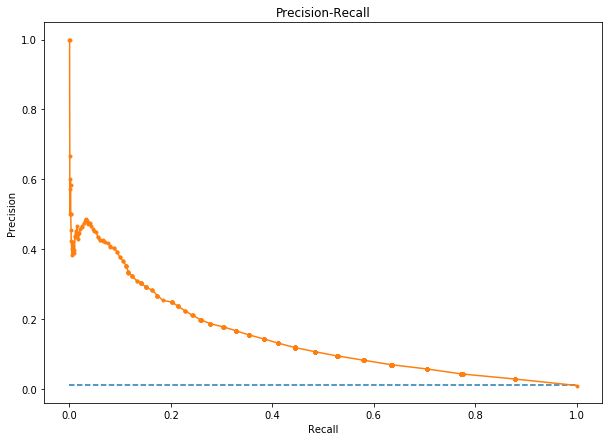

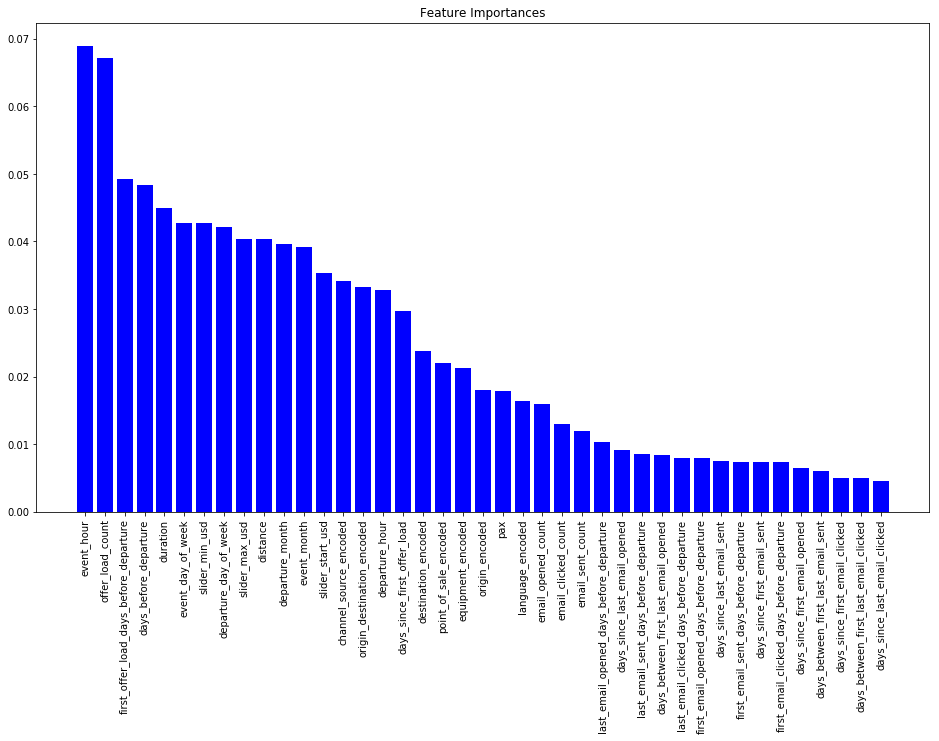

In [17]:
# run with a random subset to get the learning curves
train_and_evaluate(df_train,plot_learning_curves=False,limit=1000000)

training on 1876463 rows...
training is done!
precision 0.3790322580645161
recall 0.028460700012110936
f1 0.05294581502759941
support 8257
roc auc 0.8698131196161658


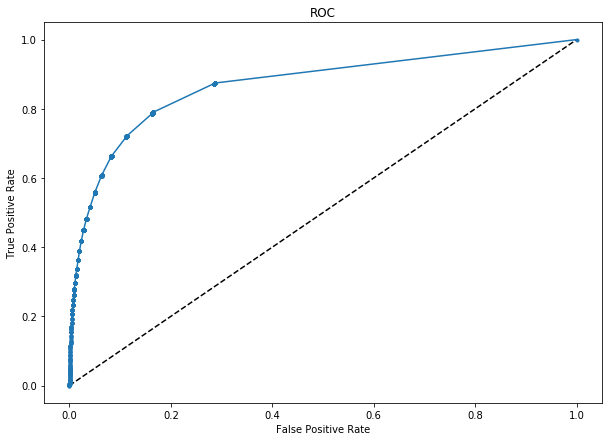

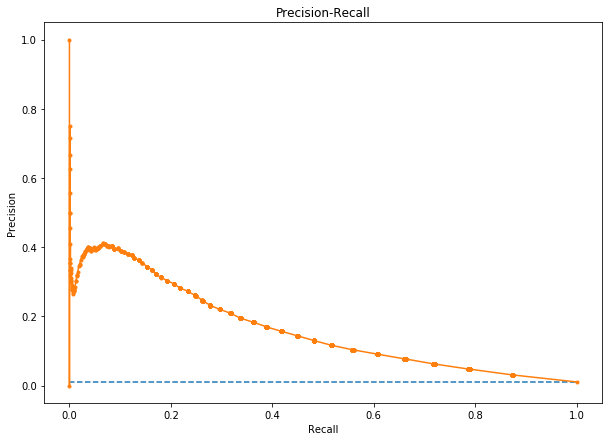

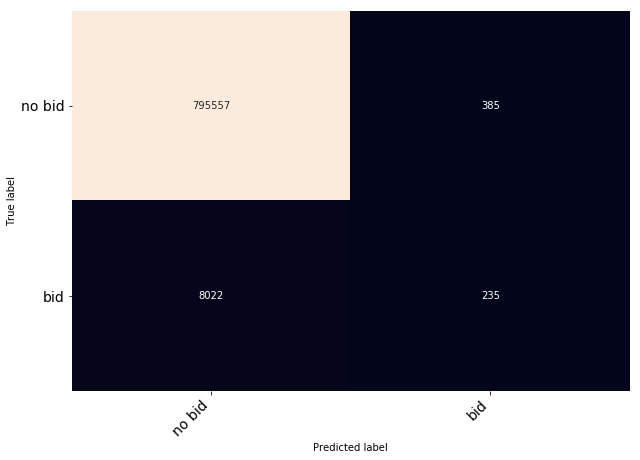

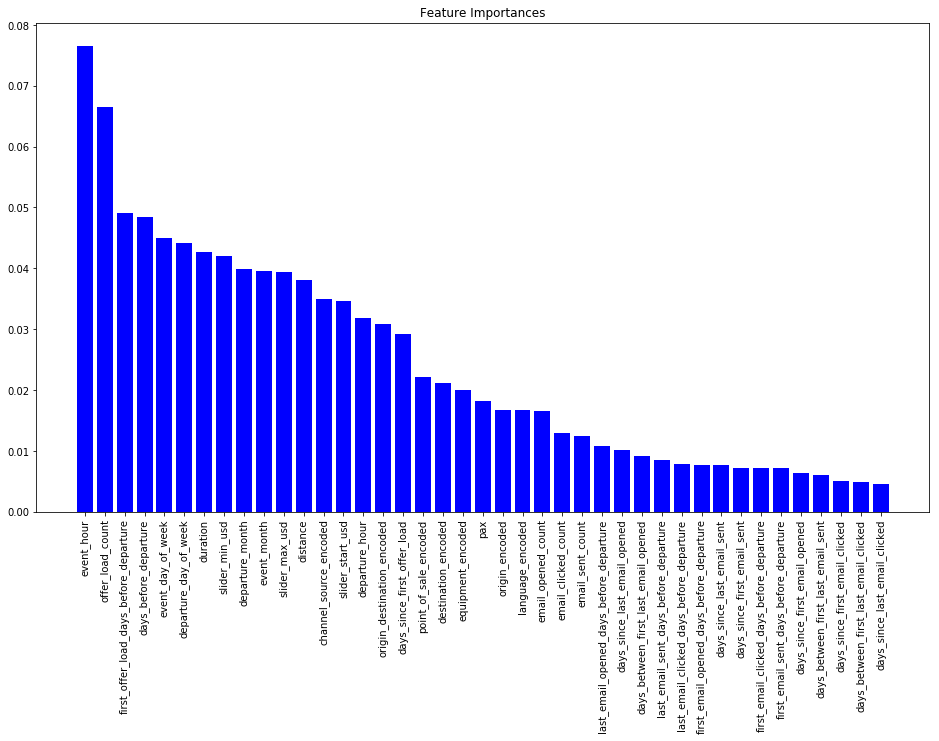

In [18]:
# run with all data
train_and_evaluate(df_train,plot_learning_curves=False,limit=None)